In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [10]:
def build_1d_cnn_only_conv_pool_3_ch_128_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=128, strides=1, 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=128*(2**int((i+1)/2)), strides=1, 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [9]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_128_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15976, 128)        3328      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5326, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 681728)            0         
_________________________________________________________________
dropout (Dropout)            (None, 681728)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                10907664  
Total params: 10,910,992
Trainable params: 10,910,992
Non-trainable params: 0
_________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0247 - acc: 0.3697
Epoch 00001: val_loss improved from inf to 1.63221, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_128_DO_checkpoint/001-1.6322.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 2.0246 - acc: 0.3697 - val_loss: 1.6322 - val_acc: 0.4938
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4087 - acc: 0.5668
Epoch 00002: val_loss improved from 1.63221 to 1.49341, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_128_DO_checkpoint/002-1.4934.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.4086 - acc: 0.5669 - val_loss: 1.4934 - val_acc: 0.5397
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1713 - acc: 0.6435
Epoch 00003: val_loss did not improve from 1.49341
36805/36

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0925 - acc: 0.9859
Epoch 00029: val_loss did not improve from 1.49341
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0925 - acc: 0.9858 - val_loss: 2.6072 - val_acc: 0.5195
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0949 - acc: 0.9846
Epoch 00030: val_loss did not improve from 1.49341
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0949 - acc: 0.9846 - val_loss: 2.6435 - val_acc: 0.5271
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0897 - acc: 0.9862
Epoch 00031: val_loss did not improve from 1.49341
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0897 - acc: 0.9863 - val_loss: 2.6252 - val_acc: 0.5295
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0798 - acc: 0.9871
Epoch 00032: val_loss did not improve from 1.49341
36805/36805 [===========

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9947
Epoch 00059: val_loss did not improve from 1.49341
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0373 - acc: 0.9947 - val_loss: 3.1576 - val_acc: 0.5302
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9935
Epoch 00060: val_loss did not improve from 1.49341
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0414 - acc: 0.9935 - val_loss: 3.2528 - val_acc: 0.5195
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9951
Epoch 00061: val_loss did not improve from 1.49341
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0371 - acc: 0.9951 - val_loss: 3.2081 - val_acc: 0.5232
Epoch 62/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9961
Epoch 00062: val_loss did not improve from 1.49341
36805/36805 [===========

Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9968
Epoch 00089: val_loss did not improve from 1.49341
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0251 - acc: 0.9968 - val_loss: 3.5090 - val_acc: 0.5248
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9965
Epoch 00090: val_loss did not improve from 1.49341
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0283 - acc: 0.9965 - val_loss: 3.5442 - val_acc: 0.5269
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9969
Epoch 00091: val_loss did not improve from 1.49341
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0257 - acc: 0.9969 - val_loss: 3.5757 - val_acc: 0.5220
Epoch 92/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9952
Epoch 00092: val_loss did not improve from 1.49341
36805/36805 [===========

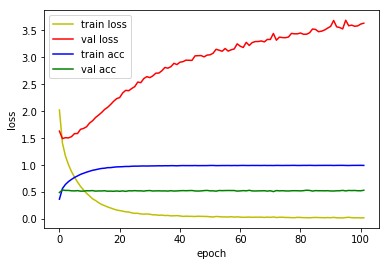

4815/4815 [==============================] - 3s 622us/sample - loss: 1.5713 - acc: 0.5067
Loss: 1.5712665378366553 Accuracy: 0.50674975

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8144 - acc: 0.4209
Epoch 00001: val_loss improved from inf to 1.36917, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_128_DO_checkpoint/001-1.3692.hdf5
36805/36805 [==============================] - 125s 3ms/sample - loss: 1.8143 - acc: 0.4209 - val_loss: 1.3692 - val_acc: 0.5816
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2141 - acc: 0.6318
Epoch 00002: val_loss improved from 1.36917 to 1.16543, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_128_DO_checkpoint/002-1.1654.hdf5
36805/36805 [==============================] - 124s 3ms/sample - loss: 1.2140 - acc: 0.6318 - val_loss: 1.1654 - val_acc: 0.6480
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.9919
Epoch 00029: val_loss did not improve from 1.02354
36805/36805 [==============================] - 123s 3ms/sample - loss: 0.0417 - acc: 0.9919 - val_loss: 1.8510 - val_acc: 0.7032
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9902
Epoch 00030: val_loss did not improve from 1.02354
36805/36805 [==============================] - 123s 3ms/sample - loss: 0.0422 - acc: 0.9902 - val_loss: 1.8460 - val_acc: 0.7016
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9913
Epoch 00031: val_loss did not improve from 1.02354
36805/36805 [==============================] - 123s 3ms/sample - loss: 0.0402 - acc: 0.9913 - val_loss: 1.8349 - val_acc: 0.7016
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.9929
Epoch 00032: val_loss did not improve from 1.02354
36805/36805 [========

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9954
Epoch 00059: val_loss did not improve from 1.02354
36805/36805 [==============================] - 123s 3ms/sample - loss: 0.0260 - acc: 0.9954 - val_loss: 1.9834 - val_acc: 0.7184
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9961
Epoch 00060: val_loss did not improve from 1.02354
36805/36805 [==============================] - 123s 3ms/sample - loss: 0.0234 - acc: 0.9961 - val_loss: 2.0399 - val_acc: 0.7058
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9968
Epoch 00061: val_loss did not improve from 1.02354
36805/36805 [==============================] - 123s 3ms/sample - loss: 0.0225 - acc: 0.9968 - val_loss: 2.0416 - val_acc: 0.7158
Epoch 62/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9959
Epoch 00062: val_loss did not improve from 1.02354
36805/36805 [========

Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0224 - acc: 0.9966
Epoch 00089: val_loss did not improve from 1.02354
36805/36805 [==============================] - 127s 3ms/sample - loss: 0.0223 - acc: 0.9966 - val_loss: 2.1530 - val_acc: 0.7275
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9970
Epoch 00090: val_loss did not improve from 1.02354
36805/36805 [==============================] - 127s 3ms/sample - loss: 0.0206 - acc: 0.9970 - val_loss: 2.0925 - val_acc: 0.7254
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9969
Epoch 00091: val_loss did not improve from 1.02354
36805/36805 [==============================] - 127s 3ms/sample - loss: 0.0210 - acc: 0.9969 - val_loss: 2.0602 - val_acc: 0.7314
Epoch 92/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9972
Epoch 00092: val_loss did not improve from 1.02354
36805/36805 [========

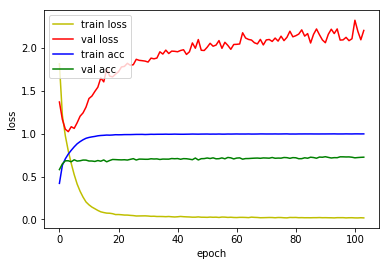

4815/4815 [==============================] - 4s 930us/sample - loss: 1.1116 - acc: 0.6563
Loss: 1.1115837047404589 Accuracy: 0.6562824

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6976 - acc: 0.4620
Epoch 00001: val_loss improved from inf to 1.15375, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_128_DO_checkpoint/001-1.1538.hdf5
36805/36805 [==============================] - 169s 5ms/sample - loss: 1.6975 - acc: 0.4620 - val_loss: 1.1538 - val_acc: 0.6546
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0506 - acc: 0.6845
Epoch 00002: val_loss improved from 1.15375 to 0.86570, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_128_DO_checkpoint/002-0.8657.hdf5
36805/36805 [==============================] - 167s 5ms/sample - loss: 1.0505 - acc: 0.6845 - val_loss: 0.8657 - val_acc: 0.7522
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9931
Epoch 00028: val_loss did not improve from 0.57198
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0289 - acc: 0.9931 - val_loss: 0.9329 - val_acc: 0.8465
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9940
Epoch 00029: val_loss did not improve from 0.57198
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0262 - acc: 0.9940 - val_loss: 0.9127 - val_acc: 0.8516
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9943
Epoch 00030: val_loss did not improve from 0.57198
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0260 - acc: 0.9943 - val_loss: 0.9427 - val_acc: 0.8495
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9923
Epoch 00031: val_loss did not improve from 0.57198
36805/36805 [========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9966
Epoch 00058: val_loss did not improve from 0.57198
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.0162 - acc: 0.9966 - val_loss: 1.1136 - val_acc: 0.8514
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9965
Epoch 00059: val_loss did not improve from 0.57198
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.0167 - acc: 0.9965 - val_loss: 1.0315 - val_acc: 0.8509
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9970
Epoch 00060: val_loss did not improve from 0.57198
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.0154 - acc: 0.9970 - val_loss: 0.9941 - val_acc: 0.8612
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9968
Epoch 00061: val_loss did not improve from 0.57198
36805/36805 [========

Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9972
Epoch 00088: val_loss did not improve from 0.57198
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0144 - acc: 0.9972 - val_loss: 1.0876 - val_acc: 0.8584
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9978
Epoch 00089: val_loss did not improve from 0.57198
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0129 - acc: 0.9978 - val_loss: 1.1644 - val_acc: 0.8488
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9971
Epoch 00090: val_loss did not improve from 0.57198
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0151 - acc: 0.9971 - val_loss: 1.0715 - val_acc: 0.8563
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9970
Epoch 00091: val_loss did not improve from 0.57198
36805/36805 [========

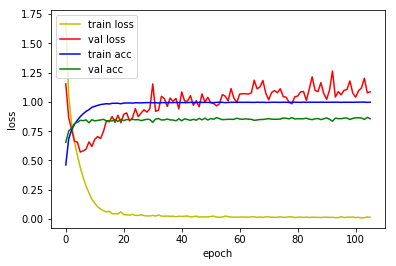

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.6639 - acc: 0.8077
Loss: 0.6639084923861555 Accuracy: 0.8076843

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7850 - acc: 0.4216
Epoch 00001: val_loss improved from inf to 1.10983, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_128_DO_checkpoint/001-1.1098.hdf5
36805/36805 [==============================] - 196s 5ms/sample - loss: 1.7849 - acc: 0.4217 - val_loss: 1.1098 - val_acc: 0.6564
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9409 - acc: 0.7132
Epoch 00002: val_loss improved from 1.10983 to 0.68557, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_128_DO_checkpoint/002-0.6856.hdf5
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.9409 - acc: 0.7132 - val_loss: 0.6856 - val_acc: 0.8022
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9936
Epoch 00056: val_loss did not improve from 0.30190
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0218 - acc: 0.9936 - val_loss: 0.4561 - val_acc: 0.9341
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9949
Epoch 00057: val_loss did not improve from 0.30190
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0184 - acc: 0.9949 - val_loss: 0.4374 - val_acc: 0.9371
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9943
Epoch 00058: val_loss did not improve from 0.30190
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0206 - acc: 0.9943 - val_loss: 0.4403 - val_acc: 0.9413
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9940
Epoch 00059: val_loss did not improve from 0.30190
36805/36805 [========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9965
Epoch 00086: val_loss did not improve from 0.30190
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0124 - acc: 0.9965 - val_loss: 0.4734 - val_acc: 0.9369
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0159 - acc: 0.9958
Epoch 00087: val_loss did not improve from 0.30190
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0159 - acc: 0.9958 - val_loss: 0.4305 - val_acc: 0.9422
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9960
Epoch 00088: val_loss did not improve from 0.30190
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0146 - acc: 0.9960 - val_loss: 0.4570 - val_acc: 0.9385
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0138 - acc: 0.9964
Epoch 00089: val_loss did not improve from 0.30190
36805/36805 [========

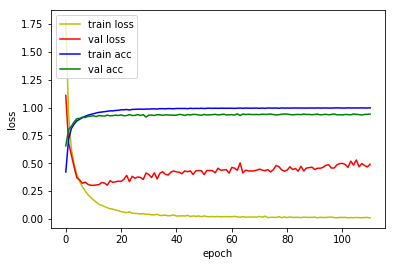

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3504 - acc: 0.8984
Loss: 0.3504037736732269 Accuracy: 0.8984424

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6411 - acc: 0.4618
Epoch 00001: val_loss improved from inf to 0.87938, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_128_DO_checkpoint/001-0.8794.hdf5
36805/36805 [==============================] - 213s 6ms/sample - loss: 1.6409 - acc: 0.4619 - val_loss: 0.8794 - val_acc: 0.7314
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7419 - acc: 0.7673
Epoch 00002: val_loss improved from 0.87938 to 0.42909, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_128_DO_checkpoint/002-0.4291.hdf5
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.7418 - acc: 0.7674 - val_loss: 0.4291 - val_acc: 0.8691
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9893
Epoch 00028: val_loss did not improve from 0.16331
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0335 - acc: 0.9893 - val_loss: 0.2133 - val_acc: 0.9534
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0304 - acc: 0.9907
Epoch 00029: val_loss did not improve from 0.16331
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0304 - acc: 0.9907 - val_loss: 0.2070 - val_acc: 0.9532
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9914
Epoch 00030: val_loss did not improve from 0.16331
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0267 - acc: 0.9914 - val_loss: 0.2372 - val_acc: 0.9539
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9912
Epoch 00031: val_loss did not improve from 0.16331
36805/36805 [========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9960
Epoch 00058: val_loss did not improve from 0.16331
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0113 - acc: 0.9960 - val_loss: 0.2845 - val_acc: 0.9543
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9957
Epoch 00059: val_loss did not improve from 0.16331
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0125 - acc: 0.9957 - val_loss: 0.2961 - val_acc: 0.9546
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9958
Epoch 00060: val_loss did not improve from 0.16331
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0129 - acc: 0.9958 - val_loss: 0.2347 - val_acc: 0.9609
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9957
Epoch 00061: val_loss did not improve from 0.16331
36805/36805 [========

Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9974
Epoch 00088: val_loss did not improve from 0.16331
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0077 - acc: 0.9974 - val_loss: 0.2597 - val_acc: 0.9648
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9959
Epoch 00089: val_loss did not improve from 0.16331
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0145 - acc: 0.9959 - val_loss: 0.2779 - val_acc: 0.9578
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9982
Epoch 00090: val_loss did not improve from 0.16331
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0059 - acc: 0.9982 - val_loss: 0.2794 - val_acc: 0.9585
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9974
Epoch 00091: val_loss did not improve from 0.16331
36805/36805 [========

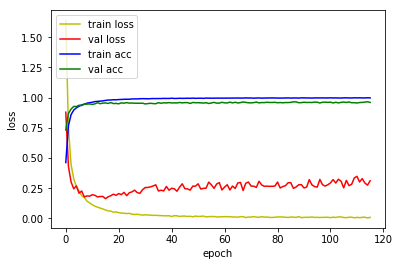

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2044 - acc: 0.9450
Loss: 0.20442304390241794 Accuracy: 0.94496363

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5510 - acc: 0.4901
Epoch 00001: val_loss improved from inf to 0.72826, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_128_DO_checkpoint/001-0.7283.hdf5
36805/36805 [==============================] - 227s 6ms/sample - loss: 1.5509 - acc: 0.4902 - val_loss: 0.7283 - val_acc: 0.7720
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6616 - acc: 0.7913
Epoch 00002: val_loss improved from 0.72826 to 0.34537, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_128_DO_checkpoint/002-0.3454.hdf5
36805/36805 [==============================] - 225s 6ms/sample - loss: 0.6615 - acc: 0.7914 - val_loss: 0.3454 - val_acc: 0.8963
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0138 - acc: 0.9959
Epoch 00058: val_loss did not improve from 0.14923
36805/36805 [==============================] - 224s 6ms/sample - loss: 0.0138 - acc: 0.9959 - val_loss: 0.2774 - val_acc: 0.9632
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9956
Epoch 00059: val_loss did not improve from 0.14923
36805/36805 [==============================] - 224s 6ms/sample - loss: 0.0158 - acc: 0.9956 - val_loss: 0.2114 - val_acc: 0.9644
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0168 - acc: 0.9950
Epoch 00060: val_loss did not improve from 0.14923
36805/36805 [==============================] - 224s 6ms/sample - loss: 0.0168 - acc: 0.9950 - val_loss: 0.2591 - val_acc: 0.9641
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9955
Epoch 00061: val_loss did not improve from 0.14923
36805/36805 [========

Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0140 - acc: 0.9965
Epoch 00088: val_loss did not improve from 0.14923
36805/36805 [==============================] - 224s 6ms/sample - loss: 0.0139 - acc: 0.9965 - val_loss: 0.2314 - val_acc: 0.9648
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0072 - acc: 0.9981
Epoch 00089: val_loss did not improve from 0.14923
36805/36805 [==============================] - 224s 6ms/sample - loss: 0.0072 - acc: 0.9981 - val_loss: 0.2638 - val_acc: 0.9660
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9970
Epoch 00090: val_loss did not improve from 0.14923
36805/36805 [==============================] - 224s 6ms/sample - loss: 0.0102 - acc: 0.9970 - val_loss: 0.2572 - val_acc: 0.9641
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9969
Epoch 00091: val_loss did not improve from 0.14923
36805/36805 [========

In [ ]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_128_DO'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_128_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_128_DO'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

In [ ]:
def build_1d_cnn_only_conv_pool_3_ch_128_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=128, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=128*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [ ]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_128_BN(conv_num=i)
    model.summary()
    del model

In [ ]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_128_BN'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_128_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_128_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

In [ ]:
def build_1d_cnn_only_conv_pool_3_ch_128_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=128, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=128*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [ ]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_128_DO_BN(conv_num=i)
    model.summary()
    del model

In [ ]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_128_DO_BN'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_128ch_64_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_128_DO_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)